# We need to preprocess EEG signals to prepare them for classification tasks.

Task 1: Load metadata and a single trial from the EEG dataset.

Task 2: Extract EEG channels and visualize the raw signal for each channel.

Task 3: Apply bad sample handling using interpolation to clean invalid segments.

Task 4: Scale the EEG signal values and apply a bandpass filter between 0.5–50 Hz.

Task 5: Apply Common Average Referencing (CAR) to reduce shared noise across channels.

Task 6: Perform baseline correction to center signals around zero using the first second as reference.

Task 7: Visualize the effect of preprocessing steps on a specific channel (C3) using overlay and subplots.

Task 8: Remove high-amplitude artifacts that exceed a defined threshold.

Task 9: Downsample the EEG signal from 250 Hz to a lower frequency (e.g., 100 Hz) for efficient processing.

# Import Libraries and important functions

In [19]:
import sys
sys.path.append('../src/utils')  # or the correct relative path to where `load_data.py` is

from load_data import (
    load_metadata,
    load_trial,
    load_by_session_and_trial
)



from scipy.signal import butter, filtfilt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import resample


# Load Metadata and EEG Trial

In [2]:
base_path = "../data"
metadata = load_metadata(base_path)
sample_row = metadata['validation'].iloc[0]
eeg_trial_df = load_trial(sample_row, dataset='validation', base_path=base_path)
print(eeg_trial_df.shape)
print(eeg_trial_df.head())


(2250, 18)
           Time            FZ            C3            CZ            C4  \
0  1.000500e+06  311426.59375  321080.50000  359498.84375  368457.43750   
1  1.000500e+06  309546.00000  311528.53125  352108.31250  366678.78125   
2  1.000500e+06  310267.96875  312397.37500  355520.78125  368320.65625   
3  1.000500e+06  312545.87500  322326.75000  364975.56250  371095.56250   
4  1.000500e+06  313246.21875  327401.46875  367259.75000  371133.31250   

             PZ           PO7            OZ           PO8      AccX      AccY  \
0  317776.90625  298857.40625  288538.78125  313009.37500  0.000244  0.820801   
1  309605.56250  296327.18750  287078.75000  310669.50000  0.002197  0.819092   
2  311393.15625  298072.96875  288286.65625  311938.46875  0.005127  0.819580   
3  320610.21875  301668.00000  290481.21875  315051.06250  0.009277  0.818359   
4  324231.18750  302074.53125  290579.93750  315634.00000  0.014648  0.819336   

       AccZ      Gyro1      Gyro2     Gyro3    Batt

# Visualize Raw EEG Channels

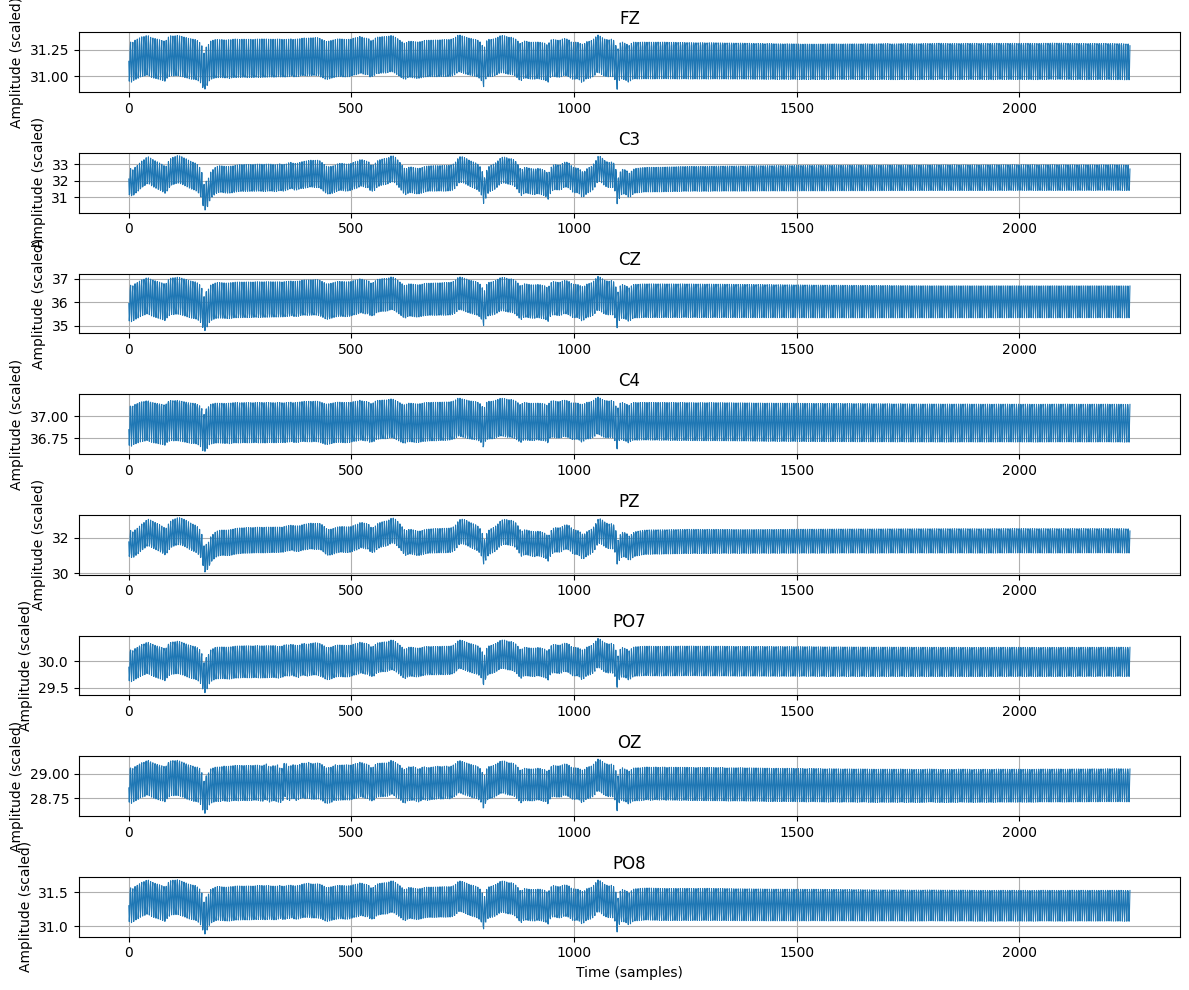

In [3]:

# Extract EEG channels
eeg_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
eeg_data = eeg_trial_df[eeg_channels].values / 1e4  # Optional scaling to make values easier to read
time = range(eeg_data.shape[0])

# Plot each EEG channel in its own subplot
plt.figure(figsize=(12, 10))
for i, channel in enumerate(eeg_channels):
    plt.subplot(len(eeg_channels), 1, i + 1)
    plt.plot(time, eeg_data[:, i], linewidth=0.8)
    plt.title(channel)
    plt.ylabel('Amplitude (scaled)')
    plt.grid(True)

plt.xlabel('Time (samples)')
plt.tight_layout()
plt.show()


#  Wrap Preprocessing in One Function

In [4]:
def preprocess_single_trial(row, dataset, base_path, 
                             sfreq=250, lowcut=0.5, highcut=50.0, 
                             scale_factor=1e4, 
                             bad_sample_method="interpolate"):
    """
    Load and preprocess a single EEG trial:
    - Handle bad samples using 'remove' or 'interpolate'
    - Extract EEG channels
    - Scale signal values
    - Apply bandpass filter

    Parameters:
    ----------
    row : pd.Series
        A row from the metadata (train/validation/test) containing trial info.
    dataset : str
        One of 'train', 'validation', or 'test'.
    base_path : str
        Root directory of the dataset.
    sfreq : int
        Sampling frequency in Hz (default: 250).
    lowcut : float
        Low cutoff frequency for bandpass filter.
    highcut : float
        High cutoff frequency for bandpass filter.
    scale_factor : float
        Value to divide raw EEG to scale down (default: 1e4).
    bad_sample_method : str
        'remove' or 'interpolate' to handle bad Validation samples.

    Returns:
    -------
    np.ndarray
        Preprocessed EEG signal with shape (n_samples, n_channels)
    """
    
    def handle_bad_samples(trial_df, method="interpolate"):
        """
        Handle bad EEG samples based on the Validation column.
        """
        if trial_df['Validation'].eq(1).all():
            return trial_df.copy()

        if method == "remove":
            return trial_df[trial_df['Validation'] == 1].reset_index(drop=True)

        elif method == "interpolate":
            trial_df = trial_df.copy()
            numeric_cols = trial_df.select_dtypes(include='number').columns
            trial_df[numeric_cols] = trial_df[numeric_cols].interpolate(method='linear', limit_direction='both')
            return trial_df.reset_index(drop=True)

        else:
            raise ValueError("Method must be 'remove' or 'interpolate'")

    def extract_clean_eeg(trial_df):
        eeg_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
        return trial_df[eeg_channels].reset_index(drop=True)

    def bandpass_filter(data, sfreq, lowcut, highcut, order=4):
        nyq = 0.5 * sfreq
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, data, axis=0)

    # Load trial
    trial_df = load_trial(row, dataset=dataset, base_path=base_path)

    # Step 1: Handle bad samples
    trial_df = handle_bad_samples(trial_df, method=bad_sample_method)

    # Step 2: Extract EEG
    eeg_clean = extract_clean_eeg(trial_df)

    # Step 3: Scale
    scaled = eeg_clean.values / scale_factor

    # Step 4: Filter
    filtered = bandpass_filter(scaled, sfreq=sfreq, lowcut=lowcut, highcut=highcut)

    return filtered

In [5]:
preprocessed_data = preprocess_single_trial(
    row=sample_row,
    dataset='validation',
    base_path=base_path,
    bad_sample_method='interpolate'  # or 'remove'
)
print(preprocessed_data.shape)
print(preprocessed_data[:5, :])  # Print first 5 samples of each channel

(2250, 8)
[[-0.04012466 -0.25618111 -0.15971188 -0.02936364 -0.22890108 -0.04690518
  -0.02464132 -0.04707162]
 [-0.13416969 -0.89480026 -0.49374846 -0.06197123 -0.71209574 -0.12759176
  -0.05927376 -0.14149018]
 [-0.09908396 -0.84856199 -0.32667265  0.01649997 -0.62190914 -0.04354645
  -0.00150646 -0.07980919]
 [ 0.01578585 -0.29311043  0.1303093   0.13277056 -0.13912618  0.11693644
   0.09211544  0.06563116]
 [ 0.05038599 -0.01535218  0.24194062  0.12683259  0.05304841  0.13117655
   0.0916303   0.09208962]]


# Apply Common Average Referencing (CAR)

In [6]:
def apply_car(eeg_data):
    """
    Apply Common Average Referencing (CAR) to EEG data.

    Parameters:
    ----------
    eeg_data : np.ndarray
        EEG data of shape (n_samples, n_channels)

    Returns:
    -------
    np.ndarray
        CAR-processed EEG data with same shape
    """
    mean_across_channels = eeg_data.mean(axis=1, keepdims=True)
    return eeg_data - mean_across_channels

In [7]:
eeg_car = apply_car(preprocessed_data)
print(eeg_car.shape)


(2250, 8)


## convert to dataframe

In [10]:
channel_names = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
eeg_df_labeled = pd.DataFrame(eeg_car, columns=channel_names)

In [11]:
eeg_df_labeled.head()

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8
0,0.063988,-0.152069,-0.055599,0.074749,-0.124789,0.057207,0.079471,0.057041
1,0.193973,-0.566658,-0.165606,0.266171,-0.383953,0.200551,0.268869,0.186652
2,0.151490,-0.597988,-0.076099,0.267074,-0.371335,0.207027,0.249067,0.170765
3,0.000622,-0.308274,0.115145,0.117607,-0.154290,0.101772,0.076951,0.050467
4,-0.046083,-0.111821,0.145472,0.030364,-0.043421,0.034708,-0.004839,-0.004379


# Apply Baseline Correction

In [12]:
def baseline_correction(eeg_df, baseline_duration_sec=1, sfreq=250):
    """
    Apply baseline correction by subtracting the mean of the first N seconds.

    Parameters:
    ----------
    eeg_df : pd.DataFrame
        EEG signal with columns as channels and rows as time samples.

    baseline_duration_sec : int
        Duration (in seconds) used for baseline correction (default: 1s)

    sfreq : int
        Sampling frequency in Hz (default: 250)

    Returns:
    -------
    pd.DataFrame
        Baseline-corrected EEG data
    """
    baseline_samples = baseline_duration_sec * sfreq
    baseline_mean = eeg_df.iloc[:baseline_samples].mean()
    corrected_df = eeg_df - baseline_mean
    return corrected_df


In [13]:
eeg_corrected = baseline_correction(eeg_df_labeled)
print(eeg_corrected.head())


         FZ        C3        CZ        C4        PZ       PO7        OZ  \
0  0.065063 -0.112129 -0.062680  0.057668 -0.104945  0.040956  0.066202   
1  0.195048 -0.526718 -0.172687  0.249091 -0.364110  0.184299  0.255600   
2  0.152565 -0.558049 -0.083180  0.249993 -0.351492  0.190776  0.235798   
3  0.001697 -0.268335  0.108064  0.100526 -0.134447  0.085521  0.063682   
4 -0.045008 -0.071882  0.138390  0.013283 -0.023577  0.018456 -0.018108   

        PO8  
0  0.049866  
1  0.179477  
2  0.163589  
3  0.043292  
4 -0.011555  


# Visualize EEG After Each Step

In [14]:
def plot_eeg_stages(signals, labels, channel_index=1, sfreq=250, channel_name='C3'):
    """
    Plot EEG signal evolution through preprocessing stages for one channel.

    Parameters:
    ----------
    signals : list of np.ndarray or pd.DataFrame
        List of EEG signals at different stages, all with shape (n_samples, n_channels)

    labels : list of str
        Labels describing each processing stage

    channel_index : int
        Index of the channel to plot (default: 1, which is C3)

    sfreq : int
        Sampling frequency in Hz

    channel_name : str
        Name of the channel being visualized
    """
    plt.figure(figsize=(12, 6))
    time_axis = [i / sfreq for i in range(signals[0].shape[0])]

    for i, signal in enumerate(signals):
        if isinstance(signal, pd.DataFrame):
            signal = signal.values
        plt.plot(time_axis, signal[:, channel_index], label=labels[i], linewidth=1)

    plt.title(f'EEG Preprocessing Stages - Channel: {channel_name}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


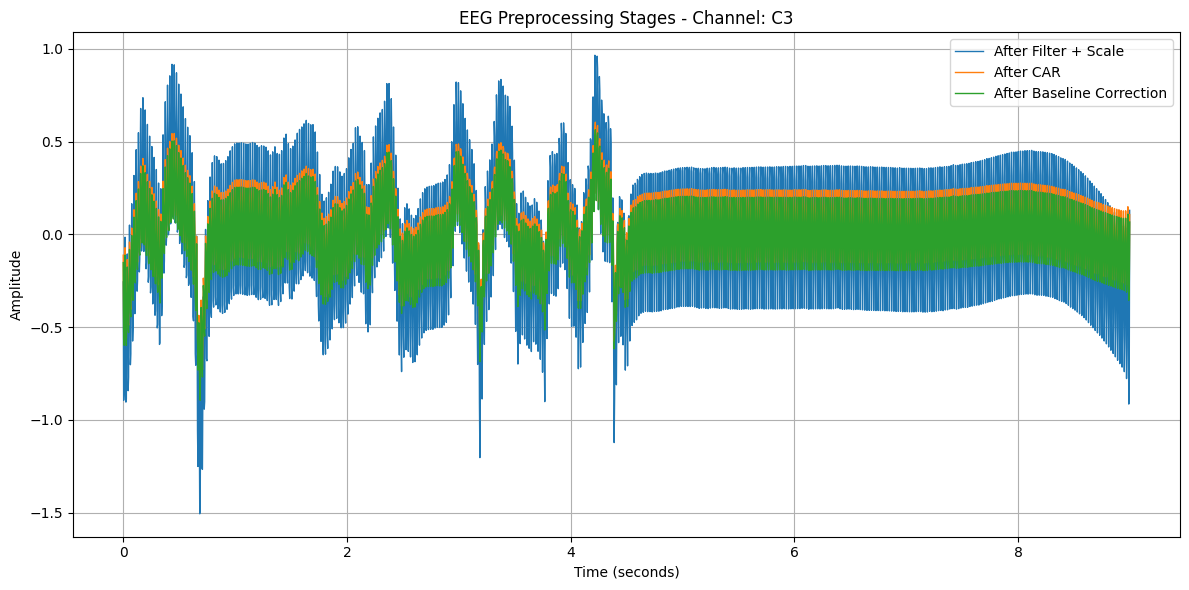

In [15]:
# Make sure each stage is available as an array or dataframe
plot_eeg_stages(
    signals=[
        preprocessed_data,        # After filter+scale (NumPy)
        eeg_corrected,            # After baseline correction (DataFrame)
        eeg_df_labeled            # After CAR (DataFrame)
    ],
    labels=[
        "After Filter + Scale",
        "After CAR",
        "After Baseline Correction"
    ],
    channel_index=1,  # Index of 'C3'
    channel_name='C3'
)


In [16]:
def plot_eeg_stages_subplots(signals, labels, channel_index=1, sfreq=250, channel_name='C3'):
    """
    Plot EEG signal evolution through preprocessing stages in separate subplots for one channel.

    Parameters:
    ----------
    signals : list of np.ndarray or pd.DataFrame
        List of EEG signals at different stages, all with shape (n_samples, n_channels)

    labels : list of str
        Labels describing each processing stage

    channel_index : int
        Index of the channel to plot (default: 1, which is C3)

    sfreq : int
        Sampling frequency in Hz

    channel_name : str
        Name of the channel being visualized
    """
    num_stages = len(signals)
    time_axis = [i / sfreq for i in range(signals[0].shape[0])]

    plt.figure(figsize=(12, 3 * num_stages))

    for i, signal in enumerate(signals):
        if isinstance(signal, pd.DataFrame):
            signal = signal.values

        plt.subplot(num_stages, 1, i + 1)
        plt.plot(time_axis, signal[:, channel_index], linewidth=1)
        plt.title(f"{labels[i]} - Channel: {channel_name}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.grid(True)

    plt.tight_layout()
    plt.show()


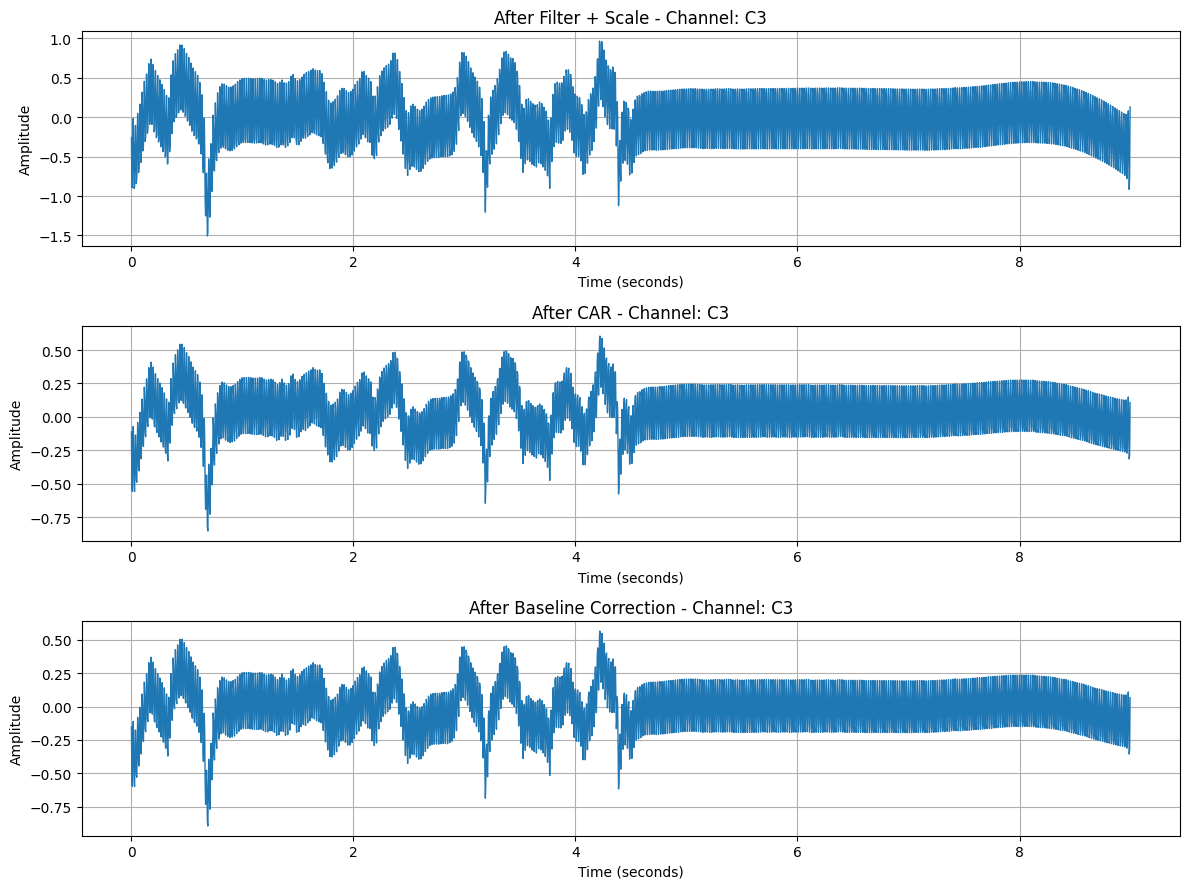

In [17]:
plot_eeg_stages_subplots(
    signals=[
        preprocessed_data,        # After filter+scale (NumPy)
        eeg_corrected,            # After baseline correction (DataFrame)
        eeg_df_labeled            # After CAR (DataFrame)
    ],
    labels=[
        "After Filter + Scale",
        "After CAR",
        "After Baseline Correction"
    ],
    channel_index=1,  # C3
    channel_name='C3'
)


# Remove High-Amplitude Artifacts

In [18]:
# eeg_corrected

def remove_large_artifacts(eeg_df, threshold=500):
    """
    Remove rows where any EEG channel exceeds a given amplitude threshold.
    This is a basic artifact rejection based on absolute value.

    Parameters:
    ----------
    eeg_df : pd.DataFrame
        Clean EEG signal (after interpolation or removal).

    threshold : float
        Amplitude threshold (in microvolts) to reject large spikes.

    Returns:
    -------
    pd.DataFrame
        EEG data with high-amplitude artifacts removed.
    """
    mask = (eeg_df.abs() > threshold).any(axis=1)
    return eeg_df[~mask].reset_index(drop=True)


In [21]:
eeg_without_artifacts = remove_large_artifacts(eeg_corrected)

# Downsample the EEG Signal

In [20]:

def downsample_signal(eeg_data, original_rate=250, target_rate=100):
    """
    Downsample EEG signal from original_rate to target_rate.

    Parameters:
    ----------
    eeg_data : np.ndarray
        EEG signal (n_samples, n_channels)

    original_rate : int
        Original sampling rate (e.g. 250 Hz)

    target_rate : int
        Target sampling rate (e.g. 100 Hz)

    Returns:
    -------
    np.ndarray
        Downsampled EEG signal
    """
    num_samples = int(eeg_data.shape[0] * target_rate / original_rate)
    return resample(eeg_data, num_samples, axis=0)


In [ ]:
eeg_downsampled = downsample_signal(eeg_without_artifacts.values)

In [25]:
channel_names = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
eeg_downsampled = pd.DataFrame(eeg_downsampled, columns=channel_names)

In [26]:
eeg_downsampled.head()

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8
0,0.105326,-0.258278,-0.098754,0.124001,-0.186859,0.090691,0.130966,0.092907
1,0.057457,-0.353642,0.033554,0.147224,-0.206671,0.117401,0.120687,0.083988
2,0.096015,-0.283785,-0.051956,0.130183,-0.204053,0.096967,0.126052,0.090578
3,0.097951,-0.404894,0.005364,0.175901,-0.263595,0.131549,0.150967,0.106756
4,0.099371,-0.293808,-0.027351,0.136079,-0.227797,0.098534,0.124652,0.090320


In [27]:
eeg_downsampled.shape

(900, 8)